# Test models of RNN-Registration project

In [1]:
import pickle
import matplotlib.pyplot as plt
import torch
import numpy as np
import time
from utils import losses
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

### Config

In [43]:
class Args():
    def __init__(self):  
        self.SERVER = 166
        self.model = 'p1-bidir-c'
        self.all_patients = False
        self.one_patient = 1
        if not self.one_patient and not self.all_patients:
            self.p_from = 0
            self.p_to = 5
        self.use_rnn = True
        self.checkpoint = '4000'
        self.batch_size = 1
        self.multi_windows = True          # is better to be True
        self.use_filtered_dataset = True   # is better to be True
        
        # means eihter to filter (src, trg) pairs that doesn't have same organs
        self.filter_by_organ_consistency = False
        if self.filter_by_organ_consistency:
            self.filter_neqs = True
        
        # if rnn
        self.rnn_hidden_dim = 32
        self.rnn_mid_flow_size = 16
        
        # if multi windows.
        # in testing, these two parameters should remain 2 and 0, because
        # we want to pass (src, trg) pairs to model individually
        self.window = 2
        self.step = 0
        
        if self.SERVER == 168:
            self.data_base = '/home/khalili/kian-data/'
            self.models_base = '/home/khalili/kian-data/saved-models/'
        elif self.SERVER == 166:
            self.data_base = '/HDD/vxm-models/structured-data/'
            self.models_base = '/HDD/kian/saved-models/cDir/'
        
args = Args()

### Reading data

In [33]:
with open(f'{args.data_base}{"filtered" if args.use_filtered_dataset else "unfiltered"}_images.pkl', 'rb') as f:
    pre_images = pickle.load(f)

with open(f'{args.data_base}{"filtered" if args.use_filtered_dataset else "unfiltered"}_labels.pkl', 'rb') as f:
    pre_labels = pickle.load(f)

images, labels = [], []
for i, img in pre_images.items():
    images.append(torch.from_numpy(img))
    
for i, lb in pre_labels.items():
    labels.append(torch.from_numpy(lb))    

# Normalize        
for i, img in enumerate(images):
    images[i] = (img/img.max()).float()
for i, lb in enumerate(labels):
    labels[i] = (lb/lb.max()).float()

### Dataloader

In [34]:
class Dataset_(Dataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.image_size = images[0].shape[1:]
        self.ndims = len(self.image_size)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        outputs = [self.images[index], self.labels[index]]
        return tuple(outputs)
    

def get_dataloader(images, labels, batch_size, shuffle=False, pin_memory=False, workers=0):
    dataset = Dataset_(images, labels)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, pin_memory=pin_memory, num_workers=workers)
    return dataloader


if args.all_patients:
    dataloader = get_dataloader(images, labels, args.batch_size)
    print(f'___dataloader filled with all data___')
elif args.one_patient:
    dataloader = get_dataloader([images[args.one_patient]], [labels[args.one_patient]], args.batch_size)
    print(f'___dataloader filled with patient number {args.one_patient}___')
elif args.p_to:
    dataloader = get_dataloader(images[args.p_from:args.p_to], labels[args.p_from:args.p_to], args.batch_size)
    print(f"____dataloader filled with patients range: {args.p_from}: {args.p_to}____")
else:
    raise Exception(f"Ambiguity in Data set: all_patients: {args.all_patients}, one_patient: {args.one_patient}"
                    f" p_from: {args.p_from}, p_to: {args.p_to}")

___dataloader filled with patient number 1___


### Unet_ConvLSTM model

In [35]:
import torch.nn as nn
from models.unet_convlstm import Unet_ConvLSTM
from models.unet import Unet
from models2.convlstm import ConvLSTM
from utils.spatial_transform import SpatialTransformer


class Unet_RNN(nn.Module):
    def __init__(self, image_size, args):
        super(Unet_RNN, self).__init__()
        self.image_size = image_size
        self.ndims = len(image_size)
        Conv = getattr(nn, 'Conv%dd' % self.ndims)

        # Unet
        enc_nf = [16, 32, 32, 32]
        dec_nf = [32, 32, 32, 32, 32, 16, 16]
        self.unet = Unet(inshape=image_size, infeats=2, nb_features=[enc_nf, dec_nf])
        self.unet_downsize = Conv(in_channels=self.unet.final_nf, out_channels=2, kernel_size=3, padding=1)

        # RNN
        self.hidden_dim = args.rnn_hidden_dim
        self.downsize_conv_1 = Conv(in_channels=self.hidden_dim, out_channels=args.rnn_mid_flow_size, kernel_size=3, padding=1)
        self.downsize_conv_2 = Conv(in_channels=args.rnn_mid_flow_size, out_channels=2, kernel_size=3, padding=1)
        self.rnn = ConvLSTM(img_size=image_size, input_dim=self.unet.final_nf, hidden_dim=self.hidden_dim,
                            kernel_size=(3, 3), bidirectional=False, return_sequence=True, batch_first=False)

        self.spatial_transformer = SpatialTransformer(size=image_size)

    def forward(self, images, labels=None, use_rnn=True):

        # shape of imgs/lbs: (seq_size, bs, 1, W, H)
        # shape of unet_out: (seq_size - 1, bs, 2, W, H)
        # shape of flows: (seq_size - 1, bs, 2, W, H)
        # shape of moved_images = (seq_size - 1, bs, 1, W, H)

        # Forward: registering slice i to i + 1
        sources_, targets_ = images[:-1], images[1:]
        src_trg_zip = zip(sources_, targets_)
        if use_rnn:
            unet_out = torch.cat(
                [self.unet(torch.cat([src, trg], dim=1)).unsqueeze(0) for src, trg in src_trg_zip], dim=0)
            rnn_out, last_states, _ = self.rnn(unet_out)
            x = rnn_out[0].squeeze(0)
            x = self.downsize_conv_1(x)
            x = torch.nn.functional.leaky_relu(x)
            flows = self.downsize_conv_2(x).unsqueeze(1)
        else:
            flows = torch.cat(
                [self.unet_downsize(self.unet(torch.cat([src, trg], dim=1))).unsqueeze(0)
                 for src, trg in src_trg_zip], dim=0)

        moved_images_ = torch.cat(
            [self.spatial_transformer(src, flow).unsqueeze(0) for src, flow in zip(sources_, flows[:])], dim=0)

        # Backward: registering moved image back to its source slice
        src_trg_zip = zip(moved_images_, sources_)
        if use_rnn:
            unet_out = torch.cat(
                [self.unet(torch.cat([src, trg], dim=1)).unsqueeze(0) for src, trg in src_trg_zip], dim=0)
            rnn_out, last_states, _ = self.rnn(unet_out)
            x = rnn_out[0].squeeze(0)
            x = self.downsize_conv_1(x)
            x = torch.nn.functional.leaky_relu(x)
            backward_flows = self.downsize_conv_2(x).unsqueeze(1)
        else:
            backward_flows = torch.cat(
                [self.unet_downsize(self.unet(torch.cat([src, trg], dim=1))).unsqueeze(0)
                 for src, trg in src_trg_zip], dim=0)

        backward_moved_images_ = torch.cat(
            [self.spatial_transformer(src, flow).unsqueeze(0) for src, flow
             in zip(moved_images_, backward_flows[:])], dim=0)

        if labels is not None:
            # We use labels only for testing, not training.
            lbs_sources_ = labels[:-1]
            moved_labels = torch.cat(
                [self.spatial_transformer(src, flow).unsqueeze(0)
                 for src, flow in zip(lbs_sources_, flows[:])], dim=0)
            return moved_images_, moved_labels, backward_moved_images_
        else:
            return moved_images_, backward_moved_images_

In [36]:
model = Unet_RNN(dataloader.dataset.image_size, args)
model.to('cuda')
model.eval()

(3, 3)


Unet_RNN(
  (unet): Unet(
    (encoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(2, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (1): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (2): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
      (3): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (activation): LeakyReLU(negative_slope=0.2)
        )
      )
    )
    (decoder): ModuleList(
      (0): ModuleList(
        (0): ConvBlock(
          (main): Conv2d(32, 32, kernel_size=(3, 3), str

### Loading model

In [44]:
PATH = f'{args.models_base}{args.model}/{args.checkpoint}.pt'
checkpoint = torch.load(PATH)
try:
    model.load_state_dict(checkpoint['model_state_dict'])
except:
    model.load_state_dict(checkpoint)

In [45]:
def dice(y_true, y_pred):
    zero = torch.zeros_like(y_true)
    one = torch.ones_like(y_true)
    y_true = torch.where(y_true > 0, one, zero)
    y_pred = torch.where(y_pred > 0, one, zero)

    dices = []
    for i in range(y_true.shape[0]):
        a, b = y_true[i], y_pred[i]
        top = 2 * np.multiply(a, b).sum()
        bottom = a.sum() + b.sum()
        dices.append(top / bottom)
    return dices

def check_eq(a, b):
    if len(a) != len(b):
        return False
    for i, el in enumerate(a):
        if b[i] != el:
            return False
    return True

### Testing 

In [46]:
window, step, visualization = args.window, args.step, False

dice_score = []
for d_idx, data in enumerate(dataloader):
    
    imgs, lbs = data
    bs, num_layers = imgs.shape[0], imgs.shape[1]

    # shape of imgs/lbs: (bs, seq_size, W, H) --> (seq_size, bs, 1, W, H)
    imgs = imgs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')
    lbs = lbs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')

    # shape of moved_imgs/moved_labes: (seq_size - 1, bs, 1, W, H)
    # shape of flows: (seq_size - 1, bs, 2, W, H)
    
    if args.multi_windows:
        if step == 0:
            data_ft = zip(np.arange(0, num_layers - window), np.arange(window, num_layers))
        else:
            data_ft = zip(np.arange(0, num_layers - window, step), np.arange(window, num_layers, step))
    else:
        data_ft = zip([0], [num_layers])
    
    with torch.no_grad():
        for from_, to in data_ft:
            moved_image, moved_label, _ = model(imgs[from_:to], lbs[from_:to], use_rnn=args.use_rnn)
            target, source = imgs[from_:to][1:], imgs[from_:to][:-1]
            target_label, source_label = lbs[from_:to][1:], lbs[from_:to][:-1]
            
            if args.filter_by_organ_consistency:
                if window == 2 and step == 0:
                    eq = check_eq(torch.unique(source_label), torch.unique(target_label))
                    if args.filter_neqs ^ eq:
                        continue
                else:
                    print('___CAN NOT APPLY CONSISTENCY FILTER because window and step are not proper___')
                    
                
            zero = torch.zeros_like(source_label).to('cuda')
            one = torch.ones_like(source_label).to('cuda')

            target_mask = torch.where(target_label > 0, one, zero)
            moved_mask = torch.where(moved_label > 0, one, zero)
            dice_score += dice(target_mask.cpu(), moved_mask.cpu())

            
            if visualization:
                fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 14))
                ax1.imshow(source_label[0][0][0].cpu())
                ax1.title.set_text('source')
                ax2.imshow(moved_label[0][0][0].cpu())
                ax2.title.set_text('moved')
                ax3.imshow(target_label[0][0][0].cpu())
                ax3.title.set_text('target')

                
model_summary = f'Model:        {args.model}\nuse_rnn:      {args.use_rnn}\nmulti window: {args.multi_windows}\n' +\
                f'filterByOrganConsistency:  {args.filter_by_organ_consistency}\n'
if args.filter_by_organ_consistency:
    model_summary += f'filter neqs: {args.filter_neqs}\n'
    
print()

print('dice_mean:', np.mean(dice_score), ', std:', np.std(dice_score))


dice_mean: 0.89328974 , std: 0.081418306


In [47]:
args.filter_neqs = False

### Loss curve

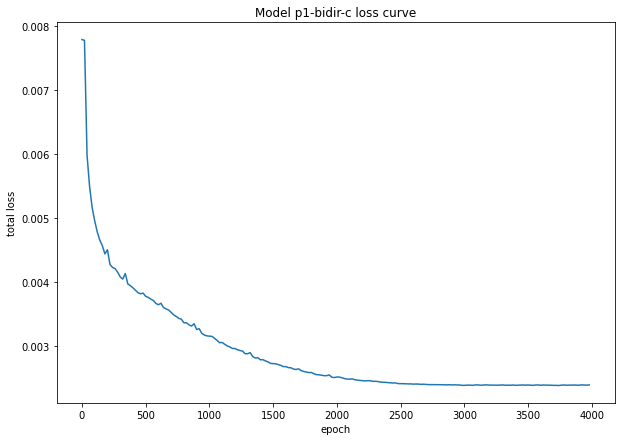

In [48]:
import json
tmet = json.load(open(f'{args.models_base}{args.model}/train_metrics.json'))

eps, loss = [], []
for m in tmet:
    
    eps.append(m.get('epoch'))
    loss.append(m.get('epoch_loss'))

plt.figure(figsize=(10, 7))
plt.plot(eps, loss);
plt.xlabel('epoch')
plt.ylabel('total loss');
plt.title(f'Model {args.model} loss curve');

### Concat several models loss curves

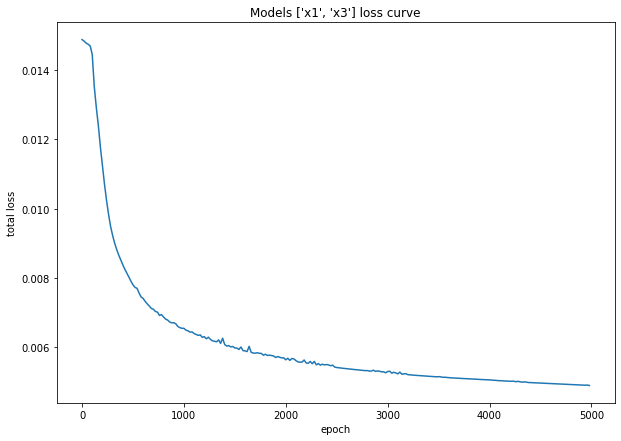

In [54]:
models_ids = ['x1', 'x3']
eps, loss = [], []
import json
for model_name in models_ids:
    tmet = json.load(open(f'{args.models_base}{model_name}/train_metrics.json'))
    for m in tmet:
        eps.append(m.get('epoch'))
        loss.append(m.get('epoch_loss'))
        
plt.figure(figsize=(10, 7))
plt.plot(eps, loss);
plt.xlabel('epoch')
plt.ylabel('total loss');
plt.title(f'Models {models_ids} loss curve');

### Visualization

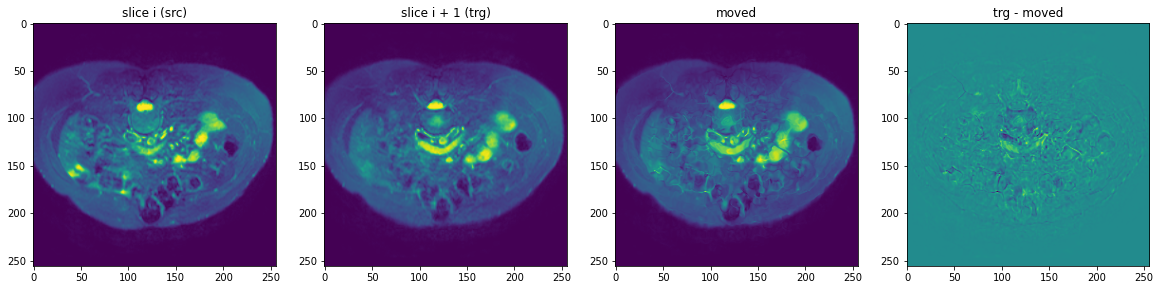

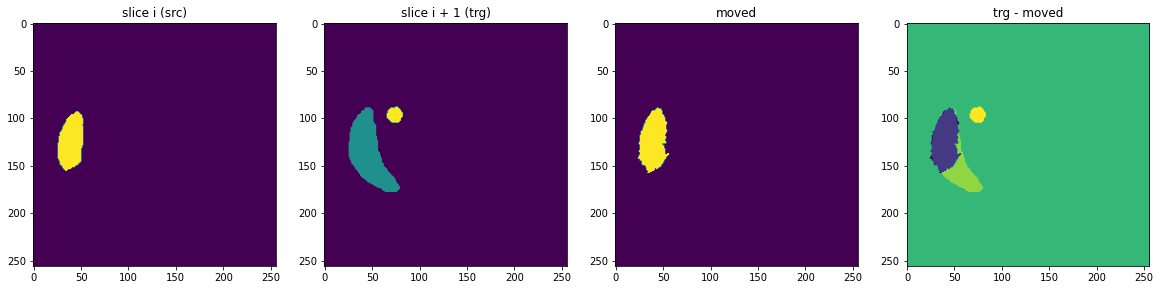

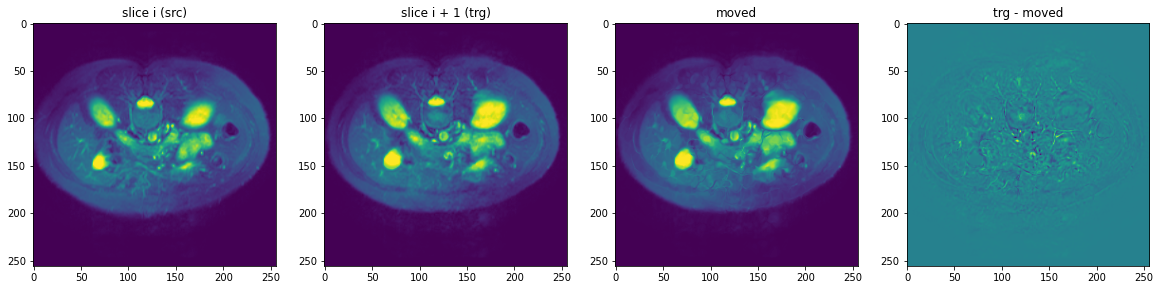

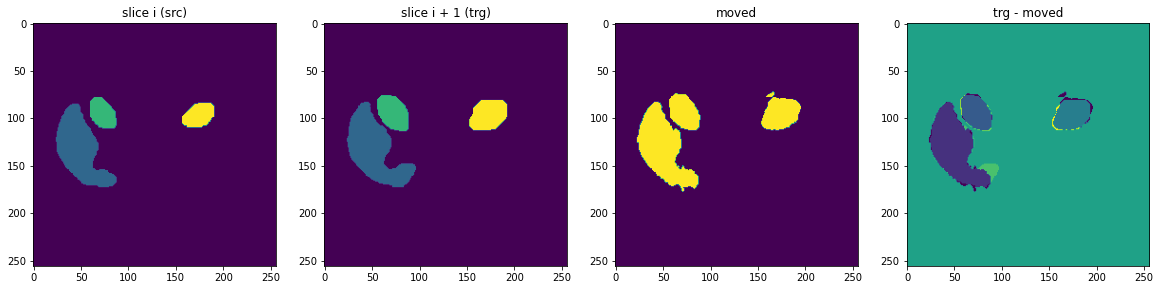

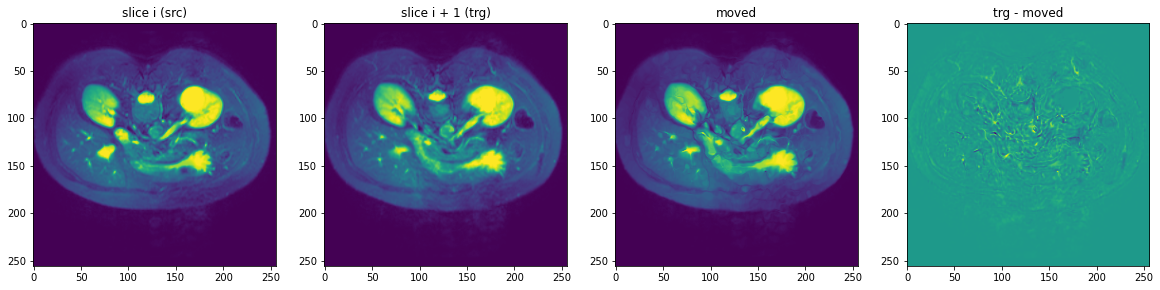

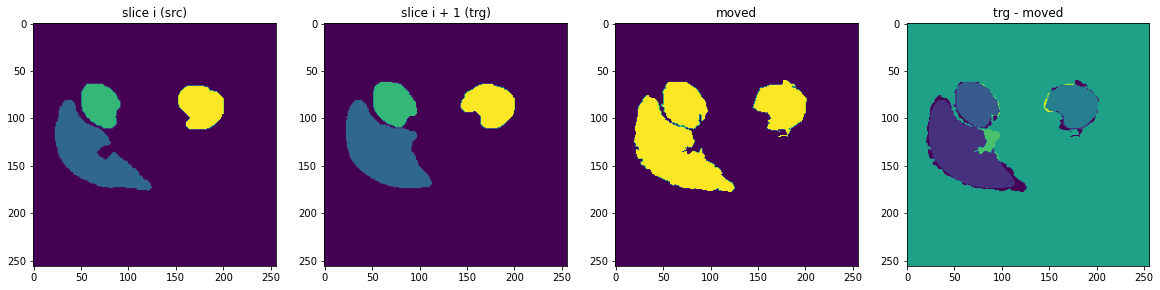

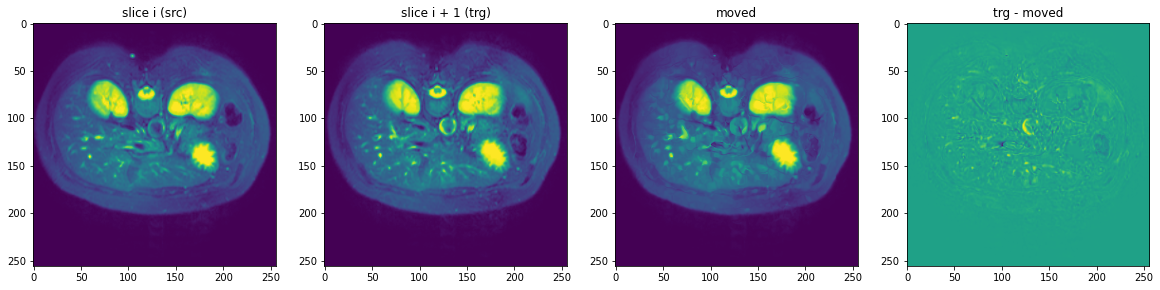

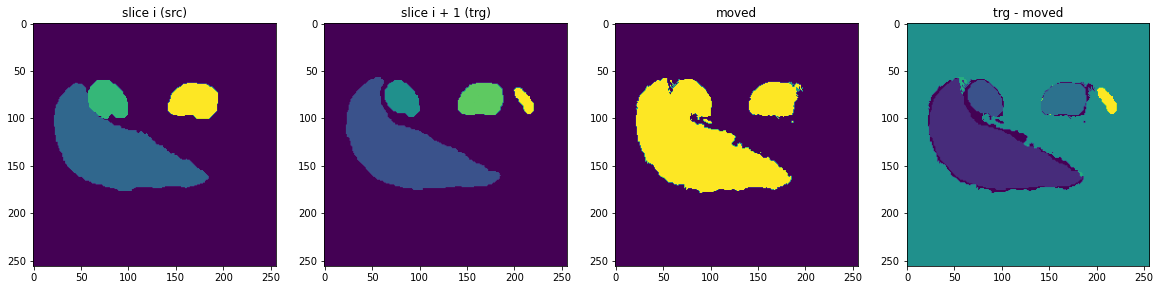

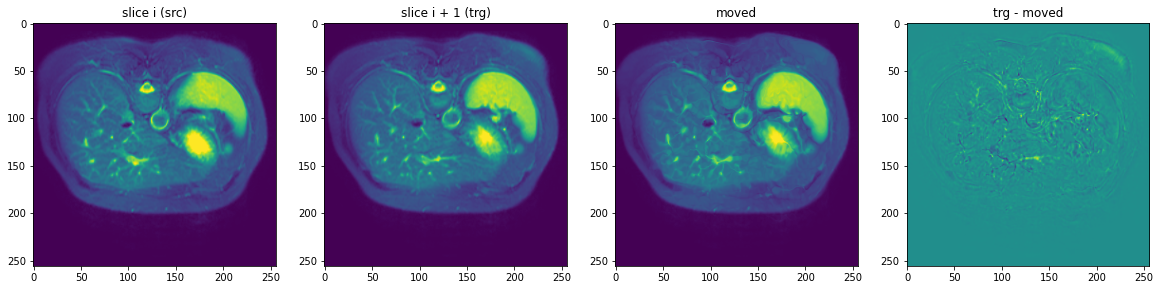

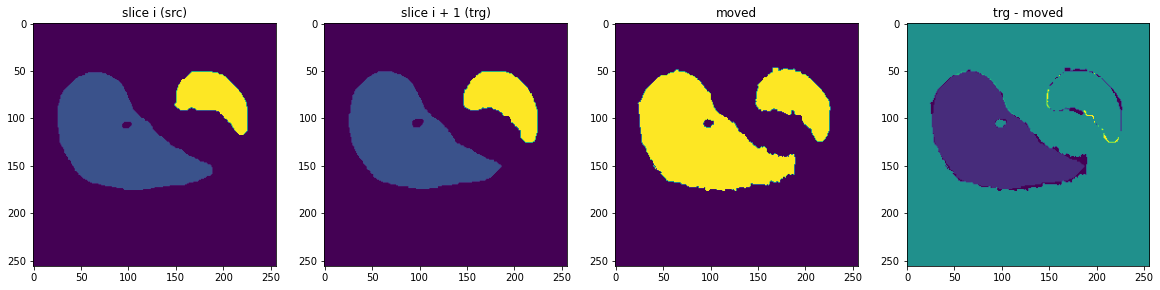

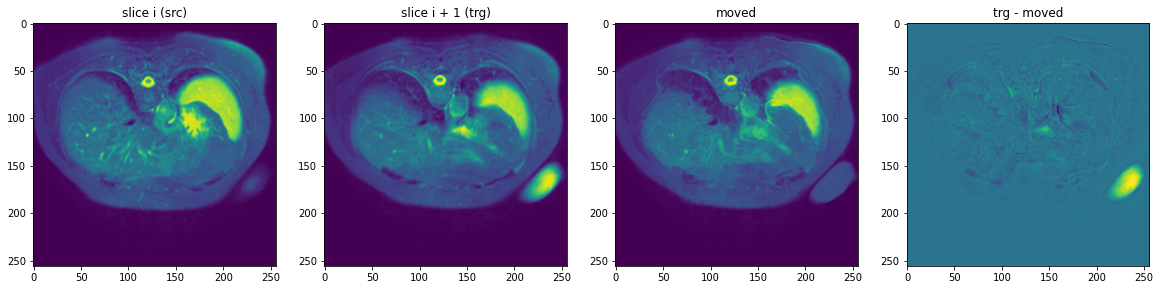

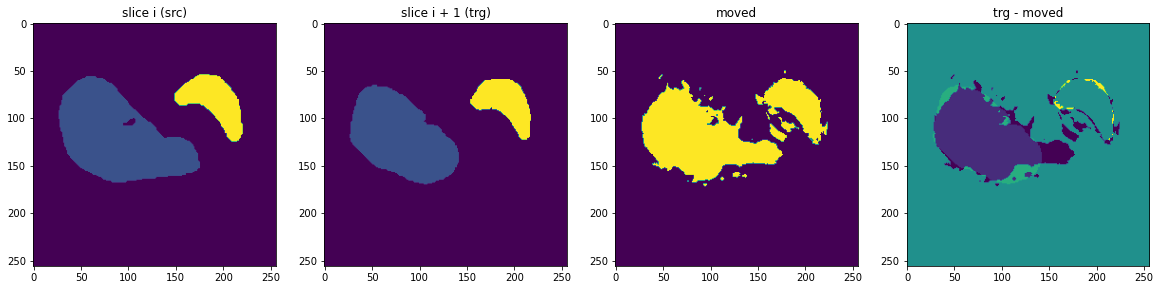

In [128]:
for d_idx, data in enumerate(dataloader):
    imgs, lbs = data
    bs, num_layers = imgs.shape[0], imgs.shape[1]
    imgs = imgs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')
    lbs = lbs.permute(1, 0, 2, 3).unsqueeze(2).to('cuda')
    if args.multi_windows:
        data_ft = zip(np.arange(0, num_layers - window, window), np.arange(window, num_layers, window))
    else:
        data_ft = zip([0], [num_layers])
    with torch.no_grad():
        for f, t in data_ft:
            fmoved, fmoved_labels, bmoved, bmoved_labels = model(imgs[f:t], lbs[f:t], use_rnn=args.use_rnn)
            f_trgs, b_trgs = imgs[f:t][1:], imgs[f:t][:-1]
            f_lbs_trgs, b_lbs_trgs = lbs[f:t][1:], lbs[f:t][:-1]
            zero = torch.zeros_like(fmoved_labels).to('cuda')
            one = torch.ones_like(fmoved_labels).to('cuda')
            f_fixed_lbs = torch.where(f_lbs_trgs > 0, one, zero)
            f_moved_lbs = torch.where(fmoved_labels > 0, one, zero)
            fdice_score += dice(f_fixed_lbs.cpu(), f_moved_lbs.cpu())
            b_fixed_lbs = torch.where(b_lbs_trgs > 0, one, zero)
            b_moved_lbs = torch.where(bmoved_labels > 0, one, zero)
            
            fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 14)) 
            ax1.imshow(b_trgs[i][0][0].cpu())
            ax1.title.set_text('slice i (src)')
            ax2.imshow(f_trgs[i][0][0].cpu())
            ax2.title.set_text('slice i + 1 (trg)')
            ax3.imshow(fmoved[i][0][0].cpu())
            ax3.title.set_text('moved')
            ax4.imshow(f_trgs[i][0][0].cpu() - fmoved[i][0][0].cpu())
            ax4.title.set_text('trg - moved')

            fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 14)) 
            ax1.imshow(b_lbs_trgs[i][0][0].cpu())
            ax1.title.set_text('slice i (src)')
            ax2.imshow(f_lbs_trgs[i][0][0].cpu())
            ax2.title.set_text('slice i + 1 (trg)')
            ax3.imshow(f_moved_lbs[i][0][0].cpu())
            ax3.title.set_text('moved')
            ax4.imshow(f_lbs_trgs[i][0][0].cpu() - f_moved_lbs[i][0][0].cpu())
            ax4.title.set_text('trg - moved')

### Some Data Analysis

Checking the effect of difference in number of organs between source and target slices

ensure matching images with labels

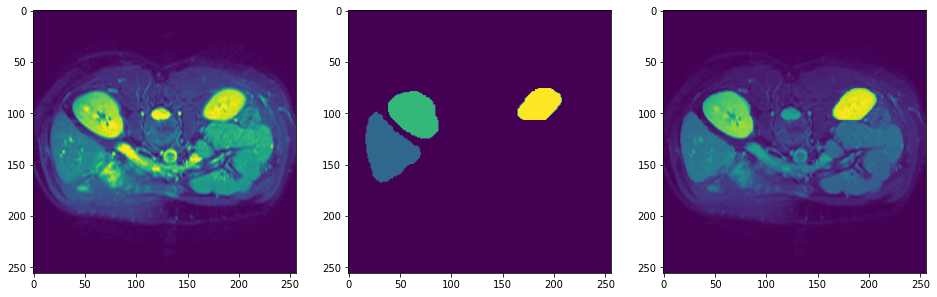

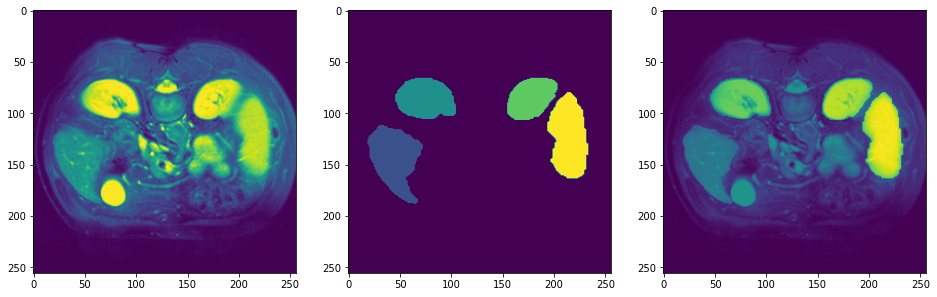

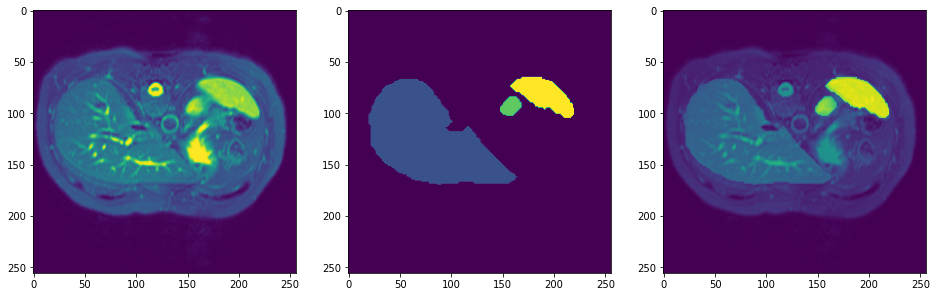

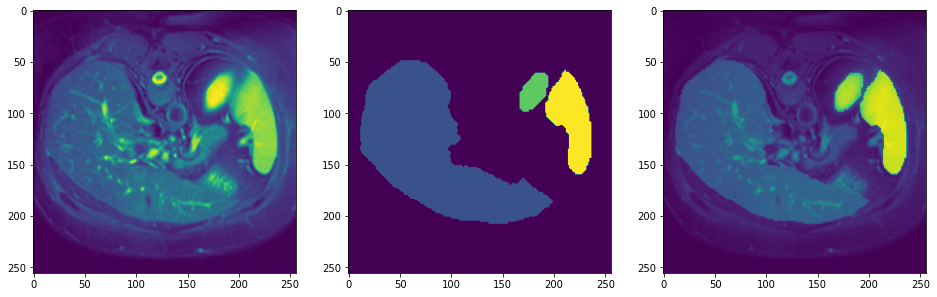

In [16]:
p_idxs = [0, 2, 5, 13, 18]
slcs = [4, 10, 15, 20]
for p_idx, slc in zip(p_idxs, slcs):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 16))
    ax1.imshow(images[p_idx][slc])
    ax2.imshow(labels[p_idx][slc])
    ax3.imshow(images[p_idx][slc] + 1 * labels[p_idx][slc])

In [25]:
def check_eq(a, b):
    if len(a) != len(b):
        return False
    for i, el in enumerate(a):
        if b[i] != el:
            return False
    return True
    


def get_dice_seperate(y_true, y_pred):
    eq_dices, neq_dices = [], []
    
    neq_list = []
    for i in range(y_true.shape[0] - 1):
        a, b = y_true[i], y_pred[i]
        
        zero = torch.zeros_like(a)
        one = torch.ones_like(a)
        c = torch.where(a > 0, one, zero)
        d = torch.where(b > 0, one, zero)
        top = 2 * np.multiply(c, d).sum()
        bottom = c.sum() + d.sum()
        
        if check_eq(np.unique(a), np.unique(b)):
            eq_dices.append((top / bottom).item())
        else:
            neq_list.append(i)
            neq_dices.append((top / bottom).item())
    return eq_dices, neq_dices, neq_list

In [28]:
all_eq, all_neq = [], []
neq_dict = {}
for i, pl in enumerate(labels):
    
    y_true = labels[i][1:]
    y_pred = labels[i][:-1]
    
    eq, neq, neq_list = get_dice_seperate(y_true, y_pred)
    all_eq += eq
    all_neq += neq
    neq_dict[i] = neq_list

In [30]:
for i, nel in neq_dict.items():
    print(f'Patient {i}:    not_equal_list: {nel}')

Patient 0:    not_equal_list: [1, 5, 13, 17, 19]
Patient 1:    not_equal_list: [0, 4, 10, 13, 14, 21]
Patient 2:    not_equal_list: [2, 5, 8, 12, 15, 22]
Patient 3:    not_equal_list: [2, 3, 14, 16, 17, 25]
Patient 4:    not_equal_list: [1, 2, 17, 18, 23]
Patient 5:    not_equal_list: [1, 3, 10, 13, 15, 21]
Patient 6:    not_equal_list: [11, 12, 13, 15, 24]
Patient 7:    not_equal_list: [1, 9, 12, 15, 19, 26]
Patient 8:    not_equal_list: [0, 3, 10, 13, 15, 23]
Patient 9:    not_equal_list: [3, 5, 10, 16, 18]
Patient 10:    not_equal_list: [2, 10, 12, 13, 19]
Patient 11:    not_equal_list: [8, 11, 13, 26]
Patient 12:    not_equal_list: [0, 1, 6, 11, 13, 20]
Patient 13:    not_equal_list: [0, 2, 14, 20, 30]
Patient 14:    not_equal_list: [0, 5, 9, 14, 15, 25]
Patient 15:    not_equal_list: [0, 6, 7, 15, 20]
Patient 16:    not_equal_list: [2, 9, 13, 20]
Patient 17:    not_equal_list: [0, 6, 7, 12, 14, 20]
Patient 18:    not_equal_list: [5, 10, 12, 15, 23]
Patient 19:    not_equal_list: [

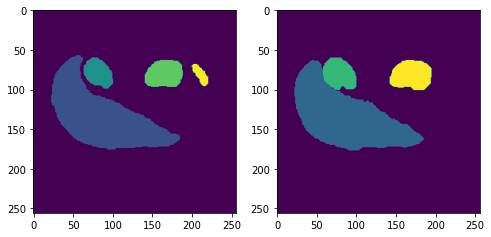

In [32]:
pid, s = 3, 14
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 12))
ax1.imshow(labels[pid][1:][s])
ax2.imshow(labels[pid][:-1][s]);

In [33]:
import warnings
warnings.simplefilter("ignore")

same mean: 0.8744
diff mean: 0.7875


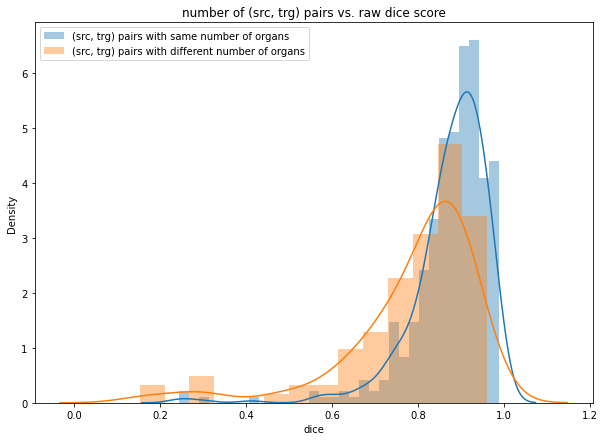

In [34]:
import seaborn as sns
import pandas as pd

data = pd.DataFrame()
data['dice'] = all_eq + all_neq
data['same'] = [1 for _ in range(len(all_eq))] + [0 for _ in range(len(all_neq))]

plt.figure(figsize=(10, 7))
sns.distplot(data.dice[data.same==1], label="(src, trg) pairs with same number of organs");
sns.distplot(data.dice[data.same==0], label="(src, trg) pairs with different number of organs");
plt.title("number of (src, trg) pairs vs. raw dice score")
plt.legend()
print('same mean:', round(np.mean(all_eq), 4))
print('diff mean:', round(np.mean(all_neq), 4))